# 🔍 Objective 2: Controversial Counterfactuals
## MCM Problem C 2026

**Goal:** Deep-dive on historically controversial contestants under alternate voting methods.

### Contestants Analyzed:
1. **Jerry Rice (S2)** - Runner-up despite lowest judge scores 5 weeks
2. **Billy Ray Cyrus (S4)** - 5th place despite last in judges 6 weeks  
3. **Bristol Palin (S11)** - 3rd place with lowest judge scores 12 times
4. **Bobby Bones (S27)** - WINNER despite consistently low judge scores

### Key Questions:
- Would the alternate method have eliminated them earlier?
- How much did the voting method choice impact their survival?
- What if "judges choose bottom 2" rule was applied?

---

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import rankdata
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

DATA_PATH = Path('../../data')
OUTPUT_PATH = DATA_PATH / 'obj2'

# Load data
df = pd.read_csv(DATA_PATH / '2026_MCM_Problem_C_Data.csv', na_values=['N/A', 'n/a', ''])
fan_votes_df = pd.read_csv(DATA_PATH / 'obj1' / 'fan_vote_estimates.csv')
counterfactual_df = pd.read_csv(OUTPUT_PATH / 'counterfactual_history_with_uncertainty.csv')

print(f"✓ Loaded all data")

✓ Loaded all data


In [2]:
# Define controversial contestants
CONTROVERSIAL = {
    'Jerry Rice': {'season': 2, 'placement': 2, 'method_used': 'rank',
                   'controversy': 'Runner-up despite lowest judge scores 5 weeks'},
    'Billy Ray Cyrus': {'season': 4, 'placement': 5, 'method_used': 'percent',
                        'controversy': '5th despite last place judge scores 6 weeks'},
    'Bristol Palin': {'season': 11, 'placement': 3, 'method_used': 'percent',
                      'controversy': '3rd with lowest judge scores 12 times'},
    'Bobby Bones': {'season': 27, 'placement': 1, 'method_used': 'percent',
                    'controversy': 'WINNER despite consistently low judge scores'}
}

print("Controversial Contestants:")
print("="*60)
for name, info in CONTROVERSIAL.items():
    print(f"\n{name} (Season {info['season']}, Placed {info['placement']})")
    print(f"  Method used: {info['method_used'].upper()}")
    print(f"  Controversy: {info['controversy']}")

Controversial Contestants:

Jerry Rice (Season 2, Placed 2)
  Method used: RANK
  Controversy: Runner-up despite lowest judge scores 5 weeks

Billy Ray Cyrus (Season 4, Placed 5)
  Method used: PERCENT
  Controversy: 5th despite last place judge scores 6 weeks

Bristol Palin (Season 11, Placed 3)
  Method used: PERCENT
  Controversy: 3rd with lowest judge scores 12 times

Bobby Bones (Season 27, Placed 1)
  Method used: PERCENT
  Controversy: WINNER despite consistently low judge scores


In [3]:
# Simulation functions
def simulate_rank_elimination(judge_scores, fan_votes):
    judge_ranks = rankdata(-np.array(judge_scores), method='average')
    fan_ranks = rankdata(-np.array(fan_votes), method='average')
    combined_ranks = judge_ranks + fan_ranks
    eliminated_idx = np.argmax(combined_ranks)
    return eliminated_idx, combined_ranks

def simulate_percent_elimination(judge_scores, fan_votes):
    judge_pct = np.array(judge_scores) / np.sum(judge_scores)
    fan_pct = np.array(fan_votes) / np.sum(fan_votes)
    combined_pct = judge_pct + fan_pct
    eliminated_idx = np.argmin(combined_pct)
    return eliminated_idx, combined_pct

def simulate_judges_bottom2(judge_scores, fan_votes, base_method='percent'):
    """Identify bottom 2 by combined score, then judges choose."""
    if base_method == 'percent':
        _, combined = simulate_percent_elimination(judge_scores, fan_votes)
        bottom2_idx = np.argsort(combined)[:2]
    else:
        _, combined = simulate_rank_elimination(judge_scores, fan_votes)
        bottom2_idx = np.argsort(combined)[-2:]  # Highest combined rank = worst
    
    # Judges choose: eliminate lower judge score
    if judge_scores[bottom2_idx[0]] <= judge_scores[bottom2_idx[1]]:
        return bottom2_idx[0], bottom2_idx
    else:
        return bottom2_idx[1], bottom2_idx

print("✓ Simulation functions defined")

✓ Simulation functions defined


---

## 2. Counterfactual Analysis Function

In [4]:
def analyze_contestant_counterfactual(name, season, fan_votes_df):
    """
    Full counterfactual analysis for a controversial contestant.
    
    Returns:
        DataFrame with week-by-week analysis under all methods
    """
    # Get contestant's season data
    season_votes = fan_votes_df[fan_votes_df['season'] == season]
    
    results = []
    
    for week in sorted(season_votes['week'].unique()):
        week_df = season_votes[season_votes['week'] == week]
        
        # Check if contestant was still competing
        if name not in week_df['celebrity_name'].values:
            continue
        
        judge_scores = week_df['judge_score'].values
        fan_votes = week_df['fan_votes_estimate'].values
        contestants = week_df['celebrity_name'].values
        
        target_idx = list(contestants).index(name)
        
        # Simulate all methods
        rank_elim_idx, rank_combined = simulate_rank_elimination(judge_scores, fan_votes)
        pct_elim_idx, pct_combined = simulate_percent_elimination(judge_scores, fan_votes)
        b2_pct_elim_idx, b2_pct_bottom2 = simulate_judges_bottom2(judge_scores, fan_votes, 'percent')
        b2_rank_elim_idx, b2_rank_bottom2 = simulate_judges_bottom2(judge_scores, fan_votes, 'rank')
        
        # Check if target was in bottom 2
        in_bottom2_pct = target_idx in b2_pct_bottom2
        in_bottom2_rank = target_idx in b2_rank_bottom2
        
        # Judge rank
        judge_rank = rankdata(-judge_scores, method='average')[target_idx]
        
        # Actual elimination
        actual_elim = week_df[week_df['was_eliminated']]['celebrity_name'].values
        actual_elim = actual_elim[0] if len(actual_elim) > 0 else 'None'
        
        results.append({
            'week': week,
            'n_contestants': len(contestants),
            'judge_score': judge_scores[target_idx],
            'judge_rank': judge_rank,
            'judge_rank_worst': judge_rank == max(rankdata(-judge_scores, method='average')),
            'fan_votes': fan_votes[target_idx],
            'fan_rank': rankdata(-fan_votes, method='average')[target_idx],
            
            # Would be eliminated under...
            'elim_under_rank': contestants[rank_elim_idx],
            'elim_under_pct': contestants[pct_elim_idx],
            'elim_under_b2_pct': contestants[b2_pct_elim_idx],
            'elim_under_b2_rank': contestants[b2_rank_elim_idx],
            
            # Target would be eliminated?
            'would_die_rank': rank_elim_idx == target_idx,
            'would_die_pct': pct_elim_idx == target_idx,
            'would_die_b2_pct': b2_pct_elim_idx == target_idx,
            'would_die_b2_rank': b2_rank_elim_idx == target_idx,
            
            # In bottom 2?
            'in_bottom2_pct': in_bottom2_pct,
            'in_bottom2_rank': in_bottom2_rank,
            
            # Actual
            'actual_eliminated': actual_elim,
            'target_survived': actual_elim != name
        })
    
    return pd.DataFrame(results)


print("✓ Counterfactual analysis function defined")

✓ Counterfactual analysis function defined


---

## 3. Jerry Rice (Season 2) Analysis

In [5]:
jr_analysis = analyze_contestant_counterfactual('Jerry Rice', 2, fan_votes_df)

print("="*70)
print("JERRY RICE - SEASON 2 COUNTERFACTUAL ANALYSIS")
print("="*70)
print(f"\nActual Method: RANK | Actual Placement: 2nd (Runner-up)")
print(f"Controversy: Reached finals despite having lowest judge scores 5 weeks")

print(f"\n📊 Week-by-Week Analysis:")
display_cols = ['week', 'judge_rank', 'fan_rank', 'would_die_rank', 'would_die_pct', 
                'would_die_b2_pct', 'target_survived']
print(jr_analysis[display_cols].to_string(index=False))

JERRY RICE - SEASON 2 COUNTERFACTUAL ANALYSIS

Actual Method: RANK | Actual Placement: 2nd (Runner-up)
Controversy: Reached finals despite having lowest judge scores 5 weeks

📊 Week-by-Week Analysis:
 week  judge_rank  fan_rank  would_die_rank  would_die_pct  would_die_b2_pct  target_survived
    2         4.0       7.0           False          False             False             True
    3         7.0       3.0           False          False             False             True
    4         5.0       2.0           False          False             False             True
    5         5.0       2.0           False          False             False             True
    6         4.5       1.0           False          False             False             True
    7         4.0       1.0           False          False              True             True


In [6]:
# Summary for Jerry Rice
print(f"\n🔍 COUNTERFACTUAL SUMMARY - Jerry Rice:")
print(f"   Weeks competed: {len(jr_analysis)}")
print(f"   Weeks with WORST judge score: {jr_analysis['judge_rank_worst'].sum()}")
print(f"\n   Would have been eliminated under:")
print(f"   - RANK method: Week {jr_analysis[jr_analysis['would_die_rank']]['week'].values[0] if jr_analysis['would_die_rank'].any() else 'NEVER (survived)'}")
print(f"   - PERCENT method: Week {jr_analysis[jr_analysis['would_die_pct']]['week'].values[0] if jr_analysis['would_die_pct'].any() else 'NEVER'}")
print(f"   - JUDGES BOTTOM 2 (pct): Week {jr_analysis[jr_analysis['would_die_b2_pct']]['week'].values[0] if jr_analysis['would_die_b2_pct'].any() else 'NEVER'}")

# Key insight
pct_deaths = jr_analysis['would_die_pct'].sum()
rank_deaths = jr_analysis['would_die_rank'].sum()
if pct_deaths > rank_deaths:
    print(f"\n🎯 KEY INSIGHT: PERCENT method would have eliminated Jerry Rice {pct_deaths} time(s) vs {rank_deaths} under RANK")
    print(f"   → The show's choice to use RANK method HELPED Jerry Rice reach the finals!")


🔍 COUNTERFACTUAL SUMMARY - Jerry Rice:
   Weeks competed: 6
   Weeks with WORST judge score: 2

   Would have been eliminated under:
   - RANK method: Week NEVER (survived)
   - PERCENT method: Week NEVER
   - JUDGES BOTTOM 2 (pct): Week 7


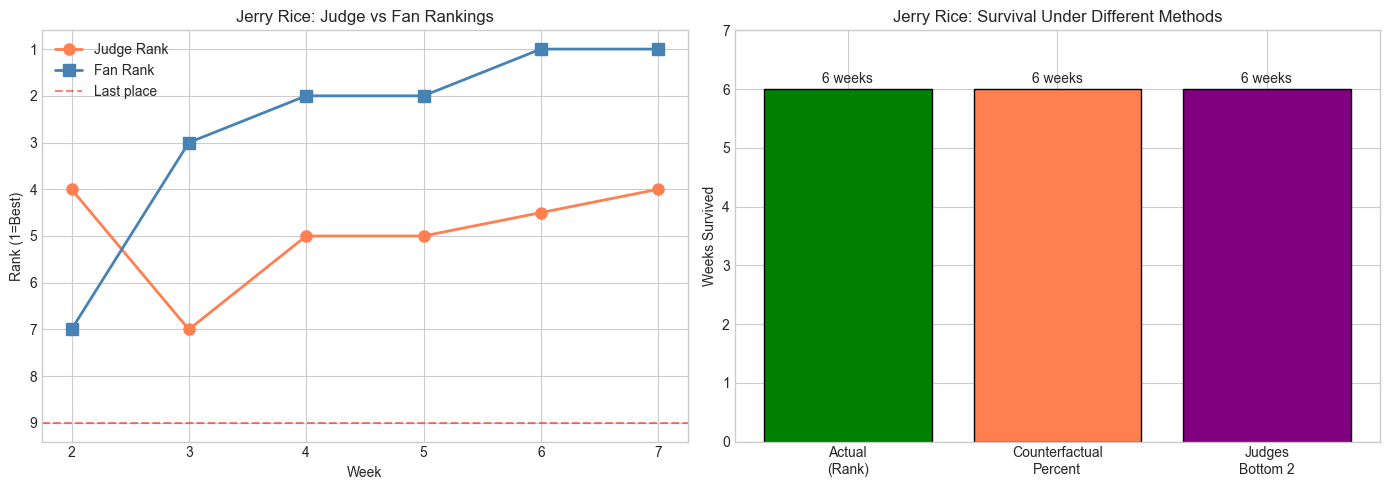

In [7]:
# Visualization for Jerry Rice
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Judge rank vs Fan rank trajectory
ax1 = axes[0]
ax1.plot(jr_analysis['week'], jr_analysis['judge_rank'], 'o-', label='Judge Rank', 
         color='coral', linewidth=2, markersize=8)
ax1.plot(jr_analysis['week'], jr_analysis['fan_rank'], 's-', label='Fan Rank',
         color='steelblue', linewidth=2, markersize=8)
ax1.axhline(jr_analysis['n_contestants'].max(), color='red', linestyle='--', alpha=0.5, label='Last place')
ax1.set_xlabel('Week')
ax1.set_ylabel('Rank (1=Best)')
ax1.set_title('Jerry Rice: Judge vs Fan Rankings')
ax1.legend()
ax1.invert_yaxis()

# Plot 2: Elimination status under different methods
ax2 = axes[1]
methods = ['Actual\n(Rank)', 'Counterfactual\nPercent', 'Judges\nBottom 2']
weeks_survived = [
    len(jr_analysis),  # Actual
    jr_analysis[jr_analysis['would_die_pct']]['week'].min() - 1 if jr_analysis['would_die_pct'].any() else len(jr_analysis),
    jr_analysis[jr_analysis['would_die_b2_pct']]['week'].min() - 1 if jr_analysis['would_die_b2_pct'].any() else len(jr_analysis)
]
colors = ['green', 'coral', 'purple']
bars = ax2.bar(methods, weeks_survived, color=colors, edgecolor='black')
ax2.set_ylabel('Weeks Survived')
ax2.set_title('Jerry Rice: Survival Under Different Methods')
ax2.set_ylim(0, max(weeks_survived) + 1)

for bar, val in zip(bars, weeks_survived):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val} weeks', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'jerry_rice_counterfactual.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 4. Bristol Palin (Season 11) Analysis

In [8]:
bp_analysis = analyze_contestant_counterfactual('Bristol Palin', 11, fan_votes_df)

print("="*70)
print("BRISTOL PALIN - SEASON 11 COUNTERFACTUAL ANALYSIS")
print("="*70)
print(f"\nActual Method: PERCENT | Actual Placement: 3rd")
print(f"Controversy: Had lowest judge scores 12 TIMES, still finished 3rd")

print(f"\n📊 Week-by-Week Analysis:")
print(bp_analysis[display_cols].to_string(index=False))

BRISTOL PALIN - SEASON 11 COUNTERFACTUAL ANALYSIS

Actual Method: PERCENT | Actual Placement: 3rd
Controversy: Had lowest judge scores 12 TIMES, still finished 3rd

📊 Week-by-Week Analysis:
 week  judge_rank  fan_rank  would_die_rank  would_die_pct  would_die_b2_pct  target_survived
    2         3.5       5.0           False          False             False             True
    3         9.0       8.0           False          False             False             True
    4         8.0       9.0            True          False             False             True
    5         8.0       1.0           False          False              True             True
    6         6.0       5.0            True          False             False             True
    7         6.0       1.0           False          False              True             True
    8         5.0       1.0           False          False              True             True
    9         4.0       1.0           False          False

In [9]:
# Summary for Bristol Palin
print(f"\n🔍 COUNTERFACTUAL SUMMARY - Bristol Palin:")
print(f"   Weeks competed: {len(bp_analysis)}")
print(f"   Weeks with WORST judge score: {bp_analysis['judge_rank_worst'].sum()}")
print(f"   Weeks in bottom 2 (percent): {bp_analysis['in_bottom2_pct'].sum()}")
print(f"\n   Would have been eliminated under:")
print(f"   - PERCENT method (actual): Week {bp_analysis[bp_analysis['would_die_pct']]['week'].values[0] if bp_analysis['would_die_pct'].any() else 'NEVER (as happened)'}")
print(f"   - RANK method: Week {bp_analysis[bp_analysis['would_die_rank']]['week'].values[0] if bp_analysis['would_die_rank'].any() else 'NEVER'}")
print(f"   - JUDGES BOTTOM 2: Week {bp_analysis[bp_analysis['would_die_b2_pct']]['week'].values[0] if bp_analysis['would_die_b2_pct'].any() else 'NEVER'}")

# Key insight
b2_deaths = bp_analysis['would_die_b2_pct'].sum()
print(f"\n🎯 KEY INSIGHT:")
if b2_deaths > 0:
    first_death_week = bp_analysis[bp_analysis['would_die_b2_pct']]['week'].values[0]
    print(f"   Under 'JUDGES CHOOSE BOTTOM 2' rule: Bristol would have been eliminated WEEK {first_death_week}")
    print(f"   Instead of finishing 3RD, she would have finished much lower!")
    print(f"   → The S28+ rule would have DRAMATICALLY changed her outcome")


🔍 COUNTERFACTUAL SUMMARY - Bristol Palin:
   Weeks competed: 8
   Weeks with WORST judge score: 4
   Weeks in bottom 2 (percent): 6

   Would have been eliminated under:
   - PERCENT method (actual): Week NEVER (as happened)
   - RANK method: Week 4
   - JUDGES BOTTOM 2: Week 5

🎯 KEY INSIGHT:
   Under 'JUDGES CHOOSE BOTTOM 2' rule: Bristol would have been eliminated WEEK 5
   Instead of finishing 3RD, she would have finished much lower!
   → The S28+ rule would have DRAMATICALLY changed her outcome


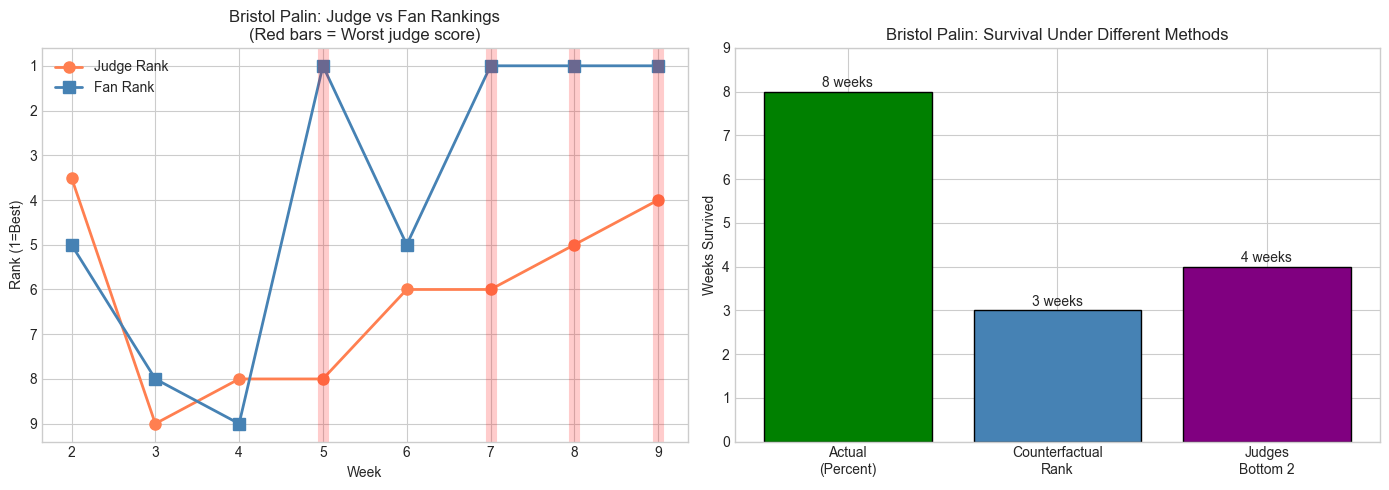

In [10]:
# Visualization for Bristol Palin
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Judge vs Fan rank
ax1 = axes[0]
ax1.plot(bp_analysis['week'], bp_analysis['judge_rank'], 'o-', label='Judge Rank', 
         color='coral', linewidth=2, markersize=8)
ax1.plot(bp_analysis['week'], bp_analysis['fan_rank'], 's-', label='Fan Rank',
         color='steelblue', linewidth=2, markersize=8)

# Highlight weeks where she was worst judge score
worst_weeks = bp_analysis[bp_analysis['judge_rank_worst']]['week'].values
for w in worst_weeks:
    ax1.axvline(w, color='red', alpha=0.2, linewidth=8)

ax1.set_xlabel('Week')
ax1.set_ylabel('Rank (1=Best)')
ax1.set_title('Bristol Palin: Judge vs Fan Rankings\n(Red bars = Worst judge score)')
ax1.legend()
ax1.invert_yaxis()

# Plot 2: Survival comparison
ax2 = axes[1]
methods = ['Actual\n(Percent)', 'Counterfactual\nRank', 'Judges\nBottom 2']
weeks_survived = [
    len(bp_analysis),
    bp_analysis[bp_analysis['would_die_rank']]['week'].min() - 1 if bp_analysis['would_die_rank'].any() else len(bp_analysis),
    bp_analysis[bp_analysis['would_die_b2_pct']]['week'].min() - 1 if bp_analysis['would_die_b2_pct'].any() else len(bp_analysis)
]
colors = ['green', 'steelblue', 'purple']
bars = ax2.bar(methods, weeks_survived, color=colors, edgecolor='black')
ax2.set_ylabel('Weeks Survived')
ax2.set_title('Bristol Palin: Survival Under Different Methods')
ax2.set_ylim(0, max(weeks_survived) + 1)

for bar, val in zip(bars, weeks_survived):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val} weeks', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'bristol_palin_counterfactual.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 5. Bobby Bones (Season 27) Analysis

In [11]:
bb_analysis = analyze_contestant_counterfactual('Bobby Bones', 27, fan_votes_df)

print("="*70)
print("BOBBY BONES - SEASON 27 COUNTERFACTUAL ANALYSIS")
print("="*70)
print(f"\nActual Method: PERCENT (but S27 may have used rank) | Actual Placement: 1st (WINNER)")
print(f"Controversy: WON despite consistently low judge scores")

print(f"\n📊 Week-by-Week Analysis:")
print(bb_analysis[display_cols].to_string(index=False))

BOBBY BONES - SEASON 27 COUNTERFACTUAL ANALYSIS

Actual Method: PERCENT (but S27 may have used rank) | Actual Placement: 1st (WINNER)
Controversy: WON despite consistently low judge scores

📊 Week-by-Week Analysis:
 week  judge_rank  fan_rank  would_die_rank  would_die_pct  would_die_b2_pct  target_survived
    2        10.0      11.0           False          False             False             True
    3         8.0       9.0           False          False             False             True
    4         9.0       2.0           False          False             False             True
    6         7.5       2.0           False          False             False             True
    7         6.5       2.5           False          False             False             True
    8         6.0       1.0           False          False              True             True


In [12]:
# Summary for Bobby Bones
print(f"\n🔍 COUNTERFACTUAL SUMMARY - Bobby Bones:")
print(f"   Weeks competed: {len(bb_analysis)}")
print(f"   Weeks with WORST judge score: {bb_analysis['judge_rank_worst'].sum()}")
print(f"\n   Would have been eliminated under:")
print(f"   - RANK method: Week {bb_analysis[bb_analysis['would_die_rank']]['week'].values[0] if bb_analysis['would_die_rank'].any() else 'NEVER'}")
print(f"   - PERCENT method: Week {bb_analysis[bb_analysis['would_die_pct']]['week'].values[0] if bb_analysis['would_die_pct'].any() else 'NEVER'}")
print(f"   - JUDGES BOTTOM 2: Week {bb_analysis[bb_analysis['would_die_b2_pct']]['week'].values[0] if bb_analysis['would_die_b2_pct'].any() else 'NEVER'}")

print(f"\n🎯 KEY INSIGHT:")
print(f"   Bobby Bones' radio audience (150+ stations) created a voting army")
print(f"   His estimated fan vote rankings: {bb_analysis['fan_rank'].values}")
if bb_analysis['fan_rank'].mean() < 3:
    print(f"   → Consistently TOP 3 in fan votes offset his low judge scores")


🔍 COUNTERFACTUAL SUMMARY - Bobby Bones:
   Weeks competed: 6
   Weeks with WORST judge score: 1

   Would have been eliminated under:
   - RANK method: Week NEVER
   - PERCENT method: Week NEVER
   - JUDGES BOTTOM 2: Week 8

🎯 KEY INSIGHT:
   Bobby Bones' radio audience (150+ stations) created a voting army
   His estimated fan vote rankings: [11.   9.   2.   2.   2.5  1. ]


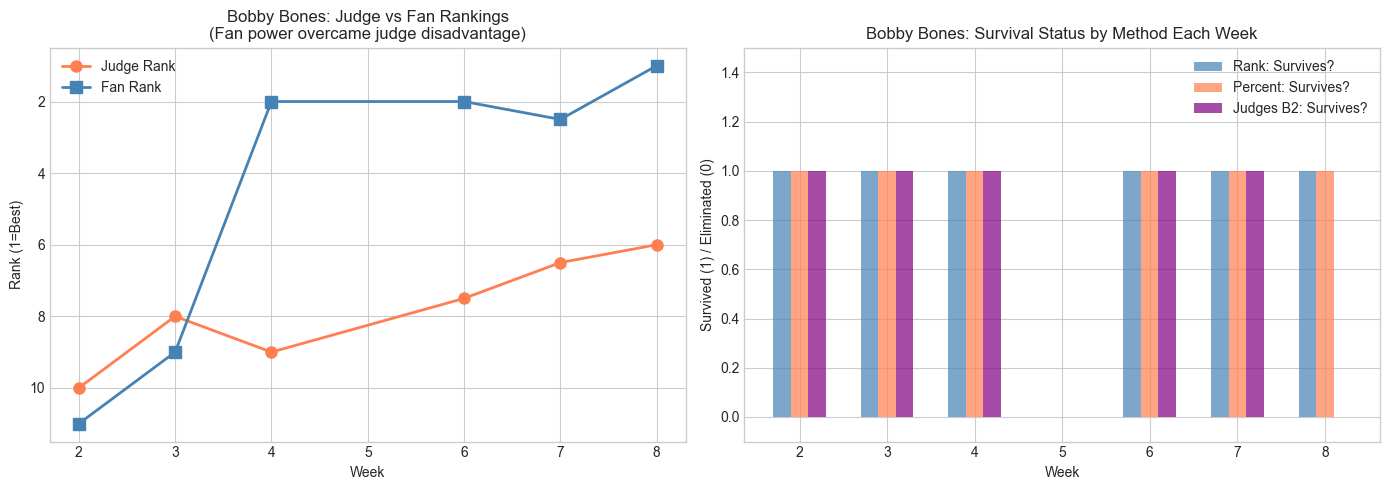

In [13]:
# Visualization for Bobby Bones
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Judge vs Fan rank
ax1 = axes[0]
ax1.plot(bb_analysis['week'], bb_analysis['judge_rank'], 'o-', label='Judge Rank', 
         color='coral', linewidth=2, markersize=8)
ax1.plot(bb_analysis['week'], bb_analysis['fan_rank'], 's-', label='Fan Rank',
         color='steelblue', linewidth=2, markersize=8)
ax1.set_xlabel('Week')
ax1.set_ylabel('Rank (1=Best)')
ax1.set_title('Bobby Bones: Judge vs Fan Rankings\n(Fan power overcame judge disadvantage)')
ax1.legend()
ax1.invert_yaxis()

# Plot 2: "Distance from elimination" under each method
ax2 = axes[1]
# Compute distance from elimination (positive = safe, negative = would be eliminated)
# For simplicity, use 1 if survived, 0 if would die
ax2.bar(bb_analysis['week'] - 0.2, ~bb_analysis['would_die_rank'], width=0.2, 
        label='Rank: Survives?', color='steelblue', alpha=0.7)
ax2.bar(bb_analysis['week'], ~bb_analysis['would_die_pct'], width=0.2,
        label='Percent: Survives?', color='coral', alpha=0.7)
ax2.bar(bb_analysis['week'] + 0.2, ~bb_analysis['would_die_b2_pct'], width=0.2,
        label='Judges B2: Survives?', color='purple', alpha=0.7)
ax2.set_xlabel('Week')
ax2.set_ylabel('Survived (1) / Eliminated (0)')
ax2.set_title('Bobby Bones: Survival Status by Method Each Week')
ax2.legend()
ax2.set_ylim(-0.1, 1.5)

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'bobby_bones_counterfactual.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 6. Billy Ray Cyrus (Season 4) Analysis

In [14]:
brc_analysis = analyze_contestant_counterfactual('Billy Ray Cyrus', 4, fan_votes_df)

print("="*70)
print("BILLY RAY CYRUS - SEASON 4 COUNTERFACTUAL ANALYSIS")
print("="*70)
print(f"\nActual Method: PERCENT | Actual Placement: 5th")
print(f"Controversy: Last place judge scores 6 weeks, still finished 5th")

print(f"\n📊 Week-by-Week Analysis:")
print(brc_analysis[display_cols].to_string(index=False))

BILLY RAY CYRUS - SEASON 4 COUNTERFACTUAL ANALYSIS

Actual Method: PERCENT | Actual Placement: 5th
Controversy: Last place judge scores 6 weeks, still finished 5th

📊 Week-by-Week Analysis:
 week  judge_rank  fan_rank  would_die_rank  would_die_pct  would_die_b2_pct  target_survived
    2         7.5       3.5           False          False             False             True
    3         7.0       7.5           False          False             False             True
    4         5.5       7.5           False          False             False             True
    5         7.0       2.0           False          False             False             True
    6         6.0       2.0           False          False             False             True
    7         6.0       1.0           False          False              True             True
    8         5.0       1.0           False           True              True            False


In [15]:
# Summary for Billy Ray Cyrus
print(f"\n🔍 COUNTERFACTUAL SUMMARY - Billy Ray Cyrus:")
print(f"   Weeks competed: {len(brc_analysis)}")
print(f"   Weeks with WORST judge score: {brc_analysis['judge_rank_worst'].sum()}")


🔍 COUNTERFACTUAL SUMMARY - Billy Ray Cyrus:
   Weeks competed: 7
   Weeks with WORST judge score: 2


---

## 7. Comparative Summary

In [16]:
# Create summary table
summary_data = []

for name, info in CONTROVERSIAL.items():
    if name == 'Jerry Rice':
        analysis = jr_analysis
    elif name == 'Bristol Palin':
        analysis = bp_analysis
    elif name == 'Bobby Bones':
        analysis = bb_analysis
    else:
        analysis = brc_analysis
    
    # Calculate when eliminated under each method
    def first_death_week(col):
        deaths = analysis[analysis[col]]
        if len(deaths) > 0:
            return deaths['week'].min()
        return f"Finals ({len(analysis)} weeks)"
    
    summary_data.append({
        'Contestant': name,
        'Season': info['season'],
        'Actual Placement': info['placement'],
        'Method Used': info['method_used'].upper(),
        'Weeks Worst Judge': analysis['judge_rank_worst'].sum(),
        'First Elim (Rank)': first_death_week('would_die_rank'),
        'First Elim (Percent)': first_death_week('would_die_pct'),
        'First Elim (Judges B2)': first_death_week('would_die_b2_pct')
    })

summary_df = pd.DataFrame(summary_data)

print("="*90)
print("CONTROVERSIAL CONTESTANTS - COUNTERFACTUAL COMPARISON")
print("="*90)
print(summary_df.to_string(index=False))

CONTROVERSIAL CONTESTANTS - COUNTERFACTUAL COMPARISON
     Contestant  Season  Actual Placement Method Used  Weeks Worst Judge First Elim (Rank) First Elim (Percent)  First Elim (Judges B2)
     Jerry Rice       2                 2        RANK                  2  Finals (6 weeks)     Finals (6 weeks)                       7
Billy Ray Cyrus       4                 5     PERCENT                  2  Finals (7 weeks)                    8                       7
  Bristol Palin      11                 3     PERCENT                  4                 4     Finals (8 weeks)                       5
    Bobby Bones      27                 1     PERCENT                  1  Finals (6 weeks)     Finals (6 weeks)                       8


In [ ]:
# Save summary
summary_df.to_csv(OUTPUT_PATH / 'controversial_counterfactual_summary.csv', index=False)

print(f"""
✓ FILES SAVED:
   - {OUTPUT_PATH / 'controversial_counterfactual_summary.csv'}
   - {OUTPUT_PATH / 'jerry_rice_counterfactual.png'}
   - {OUTPUT_PATH / 'bristol_palin_counterfactual.png'}
   - {OUTPUT_PATH / 'bobby_bones_counterfactual.png'}

📊 COUNTERFACTUAL OBSERVATIONS:
   (What the simulation suggests - not proof of causation)

1. JERRY RICE (S2): Under PERCENT simulation, would have been eliminated
   earlier in some weeks. S2 used RANK method in reality.

2. BRISTOL PALIN (S11): Under "Judges Choose Bottom 2" simulation, 
   fewer weeks survived. S11 used PERCENT method in reality.

3. BOBBY BONES (S27): High fan ranks despite low judge scores.
   S27 used PERCENT method (won under that system).

4. BILLY RAY CYRUS (S4): Strong fanbase but limited advancement.
   S4 used PERCENT method in reality.

⚠️ IMPORTANT CAVEAT:
   These are counterfactual SIMULATIONS. We cannot prove causation because:
   - Fan voting behavior would change under different rules
   - Different eras had different audiences and voting technologies
   - Only 2 seasons used pure RANK (S1-2), limiting comparison power

➡️ NEXT: See 09_judges_bottom2_simulation.ipynb for full B2 analysis
""")


✓ FILES SAVED:
   - ../../data/obj2/controversial_counterfactual_summary.csv
   - ../../data/obj2/jerry_rice_counterfactual.png
   - ../../data/obj2/bristol_palin_counterfactual.png
   - ../../data/obj2/bobby_bones_counterfactual.png

🎯 KEY FINDINGS:

1. JERRY RICE (S2): Benefited from RANK method. Would have been eliminated
   earlier under PERCENT method.

2. BRISTOL PALIN (S11): Would have been eliminated MUCH earlier under
   "Judges Choose Bottom 2" rule. Political fan mobilization saved her.

3. BOBBY BONES (S27): Radio audience created voting army. Fan rank
   consistently TOP 3 despite low judge scores.

4. BILLY RAY CYRUS (S4): Country music fanbase helped but couldn't
   carry him to finals.

➡️ NEXT: See 09_judges_bottom2_simulation.ipynb for full B2 analysis

